# Machine Learning Engineer Nanodegree - Capstone Project
## PART 6: Final Model

**Author:** Giacomo Sarchioni

In [3]:
# Module imports
import pickle as pkl
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from roc_chart import ROCChart
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from roc_chart import ROCChart
from sklearn.externals import joblib
import keras
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Conv1D, Dense, Embedding, Flatten, Dropout, LSTM, GRU, LeakyReLU
from keras.layers import MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model
from gensim.models import Word2Vec, KeyedVectors

random_seed = 42

## Import data

In [8]:
# Load reviews
with open('reviews/sentiment_reviews/sentiment.pkl', 'rb') as f:
    sentiment_reviews = pkl.load(f)
    
# Load indexes
with open('split_indexes/indexes.pkl', 'rb') as f:
    indexes = pkl.load(f)

In [9]:
# Extract scores
scores = sentiment_reviews.adj_score.values

# Extract non-test and test scores
non_test_scores = scores[indexes['non_test']]
test_scores = scores[indexes['test']]

# Extract train and validation scores
train_scores = non_test_scores[indexes['train']]
val_scores = non_test_scores[indexes['val']]

# Transform scores into categorical
scores_cat = keras.utils.to_categorical(scores,2)

# Extract non-test and test scores
non_test_scores_cat = scores_cat[indexes['non_test']]
test_scores_cat = scores_cat[indexes['test']]

# Extract train and validation scores
train_scores_cat = non_test_scores_cat[indexes['train']]
val_scores_cat = non_test_scores_cat[indexes['val']]

In [10]:
# Extract parser_zero_reviews 
parser_zero_reviews = sentiment_reviews.loc[:,'parser_zero'].values

# Extract non test parser two reviews and scores
non_test_parser_zero_reviews = parser_zero_reviews[indexes['non_test']]
test_parser_zero_reviews = parser_zero_reviews[indexes['test']]

# Extract train and validation parser-two reviews
train_parser_zero_reviews = non_test_parser_zero_reviews[indexes['train']]
val_parser_zero_reviews = non_test_parser_zero_reviews[indexes['val']]

In [11]:
parser_zero_reviews[0]

'i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador is finicky and she appreciates this product better than  most.'

In [12]:
# Extract parser_one_reviews 
parser_one_reviews = sentiment_reviews.loc[:,'parser_one'].values

# Extract non test parser two reviews and scores
non_test_parser_one_reviews = parser_one_reviews[indexes['non_test']]
test_parser_one_reviews = parser_one_reviews[indexes['test']]

# Extract train and validation parser-two reviews
train_parser_one_reviews = non_test_parser_one_reviews[indexes['train']]
val_parser_one_reviews = non_test_parser_one_reviews[indexes['val']]

In [13]:
parser_one_reviews[0]

'i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most'

## Import log reg benchmark model

In [14]:
# Load log reg benchmark
bmk_log_reg = joblib.load('bmk_models/bmk_log_reg.pkl')

# Bmk Log Reg predictions
val_bmk_log_reg_pred = bmk_log_reg.predict(val_parser_one_reviews)

## Tokenise `parser_zero` reviews

In [15]:
# Define number words in tokenizer
n_words_tokenizer = None

# Define max_len for reviews
max_len = 50

In [16]:
# Tokenise and pad  parser_zero reviews
# Import tokeniser
keras_tokenizer = Tokenizer(num_words = n_words_tokenizer)

keras_tokenizer.fit_on_texts(train_parser_one_reviews)

# Tokenise train, val and test parser_zero reviews
tokenised_train = keras_tokenizer.texts_to_sequences(train_parser_one_reviews)
tokenised_val = keras_tokenizer.texts_to_sequences(val_parser_one_reviews)
tokenised_test = keras_tokenizer.texts_to_sequences(test_parser_one_reviews)

# Transform reviews into sequences using pad_sequences
padded_train = pad_sequences(tokenised_train, maxlen=max_len, padding='post')
padded_val = pad_sequences(tokenised_val, maxlen=max_len, padding='post')
padded_test = pad_sequences(tokenised_test, maxlen=max_len, padding='post')

## Import Word2vec model and create embedding matrix

In [17]:
# # Load word2vec model
sgram_word2vec_model = Word2Vec.load('word2vec_models/default_sgram_word2vec.hdf5')

# # Extract words in word2vec model
sgram_word2vec_words = set(sgram_word2vec_model.wv.index2word)

In [18]:
# Extract first dimension of embedding matrix
if n_words_tokenizer == None:
    embedding_first_dimension = len(keras_tokenizer.word_index)+1
else:
    embedding_first_dimension = n_words_tokenizer + 1

In [19]:
# Extract second dimension of embedding matrix
embedding_second_dimension = sgram_word2vec_model.vector_size

In [20]:
print(embedding_first_dimension)
print(embedding_second_dimension)

106684
300


In [21]:
# Initialise zero array
embedding_matrix = np.zeros((embedding_first_dimension, embedding_second_dimension))

# Extract index2word dictionary from tokenise
keras_tokenizer_index2word = {i:k for k,i in keras_tokenizer.word_index.items()}

# Add word2vec to embedding matrix
for i in range(embedding_matrix.shape[0]):
    if i != 0 and keras_tokenizer_index2word[i] in sgram_word2vec_words:
        embedding_matrix[i] = sgram_word2vec_model.wv[keras_tokenizer_index2word[i]]

### Import Google pre-trained word2vec vectors

In [22]:
# # Initialise google word2vec model
google_word2vec_vectors = KeyedVectors.load_word2vec_format('word2vec_models/GoogleNews-vectors-negative300.bin', 
                                                            binary=True)

In [23]:
# # Extract words in word2vec model
google_word2vec_words = set(google_word2vec_vectors.index2word)

In [19]:
# Initialise zero array for Google word2vec embedding matrix
google_embedding_matrix = np.zeros((embedding_first_dimension, embedding_second_dimension))

# Extract index2word dictionary from tokenise
keras_tokenizer_index2word = {i:k for k,i in keras_tokenizer.word_index.items()}

# Add word2vec to embedding matrix
for i in range(google_embedding_matrix.shape[0]):
    if i != 0 and keras_tokenizer_index2word[i] in google_word2vec_words:
        google_embedding_matrix[i] = google_word2vec_vectors.word_vec(keras_tokenizer_index2word[i])

## Refined model

In [42]:
keras.backend.clear_session()

In [5]:
# Load best model
pred_model = load_model('final_model/dl_final.hdf5')

In [6]:
pred_model.get_config()

[{'class_name': 'Embedding',
  'config': {'activity_regularizer': None,
   'batch_input_shape': (None, 50),
   'dtype': 'float32',
   'embeddings_constraint': None,
   'embeddings_initializer': {'class_name': 'RandomUniform',
    'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
   'embeddings_regularizer': None,
   'input_dim': 106684,
   'input_length': 50,
   'mask_zero': False,
   'name': 'embedding_1',
   'output_dim': 300,
   'trainable': True}},
 {'class_name': 'Conv1D',
  'config': {'activation': 'linear',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dilation_rate': (1,),
   'filters': 32,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': (5,),
   'name': 'conv1d_1',
 

In [45]:
# Prediction on validation set
val_pred = pred_model.predict_classes(padded_val)

AUC score for Bmk Log Reg is 0.8609
AUC score for Refined Model is 0.8832


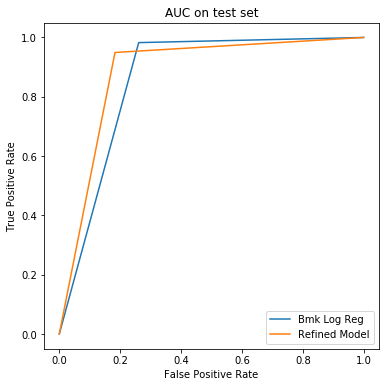

In [47]:
# Print comparison chart
comparison_chart = ROCChart(val_scores,
                            [val_bmk_log_reg_pred, val_pred],
                            ['Bmk Log Reg', 'Refined Model'],
                            'AUC on validation set')
comparison_chart.plot()